In [1]:
import pandas as pd
from datetime import date
import math
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from tensorflow import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import requests

## **Load neuralnet model and data preparation**
Carico la neuralnet trainata con i dati storici, successivamente carico i dati dal repository GitHub della Protezione Civile e li preparo, prendendo gli ultimi 14 giorni del dataframe, convertendolo in array Numpy e scalarlo a valori in range 0-1

In [2]:
## Load model

mod_name = 'https://github.com/fabrix76/COVID19-Italy-forecast/raw/master/LSTM32-dense10-dense1_nuovi_positivi_simple.h5'
model_file = requests.get(mod_name)
open('LSTM32-dense10-dense1_nuovi_positivi_simple.h5', 'wb').write(model_file.content)
model = load_model('LSTM32-dense10-dense1_nuovi_positivi_simple.h5')

In [3]:
# Scarico il dataset
df = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv", 
    usecols=['data','denominazione_regione','lat','long','ricoverati_con_sintomi','terapia_intensiva',
             'totale_ospedalizzati','isolamento_domiciliare','totale_positivi','variazione_totale_positivi',
             'nuovi_positivi','dimessi_guariti','deceduti','casi_da_sospetto_diagnostico','casi_da_screening',
             'totale_casi','tamponi','casi_testati'])
df['data'] = pd.to_datetime(df['data'])
df['data'] = pd.to_datetime(df['data'].dt.strftime('%Y-%m-%d'))
# Calcolo il totale positivi per giorno, perchè il dataset ha il totale per regione
df = df.set_index('data').resample('1d').agg({'nuovi_positivi': 'sum'})

df = df.tail(14)

In [4]:
# fix random seed for reproducibility
np.random.seed(7)

In [5]:
dataset = df.values
dataset = dataset.astype('float32')

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset) 

In [7]:
print(len(dataset))

14


## **Forecast**

Predispongo l'array per contenere i risultati, e faccio le predizioni con un ciclo. Al tempo t0 utilizzo gli ultimi 14 valori misurati, al tempo t1 tolgo la lettura più vecchia ed appendo alla fine dell'array il valore predetto dalla neuralnet per fare la previsione successiva e così via fino alla fine del ciclo

In [8]:
next_week = np.empty(1)
next_week = np.nan
next_week = np.delete(next_week, 0)
for i in range(1, 8):
    # reshape per la NN
    ndX = np.reshape(dataset, (dataset.shape[1], 1, dataset.shape[0]))
    
    #carico in r il risultato della previsione
    r = model.predict(ndX)
    
    # converto r in valore reale, è scalato tra 0 e 1
    nextdayPredict = scaler.inverse_transform(r)

    # appendo all'array il nuovo valore ed elimino il primo per eseguire la reegressione del valore successivo
    dataset = np.delete(dataset, 0,0)
    dataset = np.append(dataset, r,0)
    next_week = np.append(next_week, nextdayPredict)
    
# imposto la variabile d con la data di oggi
d = date.today()
print(d)

2020-09-29


In [9]:
# Creo il nuovo dataset
df_previsione = pd.DataFrame(pd.date_range(start=d + dt.timedelta(days=1), periods=7),columns=['Data']).set_index("Data")
df_previsione['prev_nuovi_positivi'] = next_week

In [10]:
pd.concat([df,df_previsione.astype(int)])

,nuovi_positivi,prev_nuovi_positivi
2020-09-16,1452.0,NaN
2020-09-17,1585.0,NaN
2020-09-18,1907.0,NaN
2020-09-19,1638.0,NaN
2020-09-20,1587.0,NaN
2020-09-21,1350.0,NaN
2020-09-22,1392.0,NaN
2020-09-23,1640.0,NaN
2020-09-24,1786.0,NaN
2020-09-25,1912.0,NaN


[]

<Figure size 1584x576 with 0 Axes>

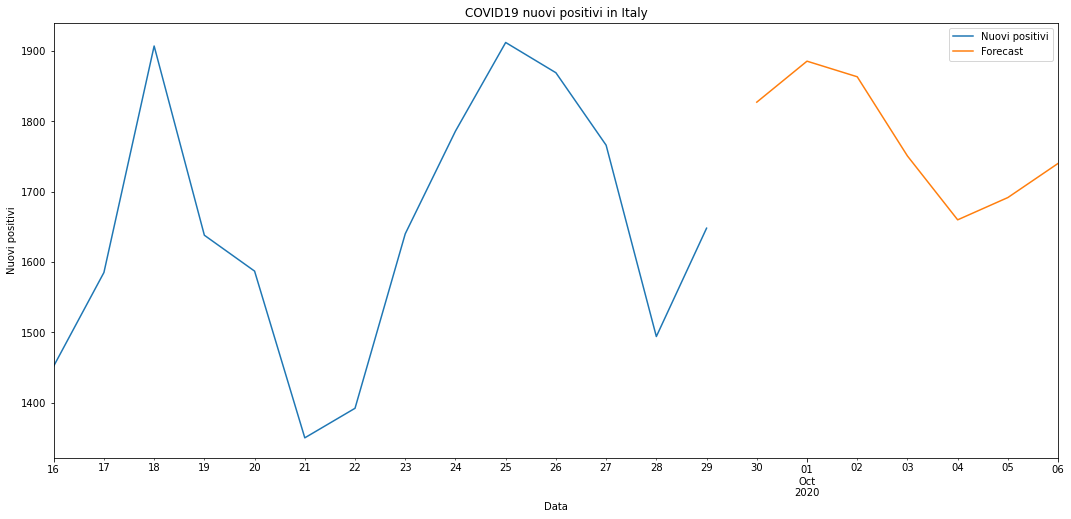

In [11]:
# plot baseline and predictions
plt.figure(figsize=(22,8))
ax = df.plot(use_index=True, y='nuovi_positivi', figsize=[18,8], title="COVID19 nuovi positivi in Italy", xlabel="Data", ylabel= "Nuovi positivi", legend="upper right", label="Nuovi positivi")
ax = df_previsione.plot(ax=ax, use_index=True, y='prev_nuovi_positivi', figsize=[18,8], title="COVID19 nuovi positivi in Italy", xlabel="Data", ylabel= "Nuovi positivi", legend="upper right", label ="Forecast")
plt.plot()

In [12]:
print(df)
print(df_previsione)

            nuovi_positivi
data                      
2020-09-16            1452
2020-09-17            1585
2020-09-18            1907
2020-09-19            1638
2020-09-20            1587
2020-09-21            1350
2020-09-22            1392
2020-09-23            1640
2020-09-24            1786
2020-09-25            1912
2020-09-26            1869
2020-09-27            1766
2020-09-28            1494
2020-09-29            1648
            prev_nuovi_positivi
Data                           
2020-09-30          1827.166870
2020-10-01          1885.438477
2020-10-02          1863.265503
2020-10-03          1750.682495
2020-10-04          1659.903198
2020-10-05          1691.589844
2020-10-06          1740.121704


In [13]:
df_previsione['Forecast'] = df_previsione['prev_nuovi_positivi'].astype(int)
del df_previsione['prev_nuovi_positivi']

In [14]:
df_previsione

,Forecast
Data,
2020-09-30,1827
2020-10-01,1885
2020-10-02,1863
2020-10-03,1750
2020-10-04,1659
2020-10-05,1691
2020-10-06,1740
